# Python for Data 29: Decision Trees
[back to index](https://www.kaggle.com/hamelg/python-for-data-analysis-index)

In the last lesson we introduced logistic regression as a predictive modeling technique for classification tasks. While logistic regression can serve as a low variance baseline model, other models often yield better predictive performance. Decision trees are another relatively simple classification model that have more expressive power than logistic regression.

# Decision Trees

If you've ever had to diagnose a problem with an appliance, car or computer, there's a good chance you've encountered a troubleshooting flowchart. A flowchart is a tree-like structure of yes/no questions that guides you through some process based on your specific situation. A decision tree is essentially a flow chart for deciding how to classify an observation: it consists of a series of yes/no or if/else decisions that ultimately assign each observation to a certain probability or class. The series of yes/no decisions can be depicted as a series of branches that lead decisions or "leaves" at the bottom of the tree.

When working with the Titanic survival prediction data last time, we suggested a simple model that classifies all women as survivors and all men as non-survivors. This model is an example of a simple decision tree with only one branch or split.

Let's create the gender-based model on the Titanic training set using decision trees in Python. First we'll load some libraries and preprocess the Titanic data:

In [52]:
import numpy as np
import pandas as pd

In [53]:
# Load and prepare Titanic data
titanic_train = pd.read_csv("train.csv")    # Read the data

# Impute median Age for NA Age values
new_age_var = np.where(titanic_train["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_train["Age"])     # Value if check is false

titanic_train["Age"] = new_age_var 

Next, we need to load and initialize scikit-learn's the decision tree model and then train the model using the sex variable:

In [54]:
from sklearn import tree
from sklearn import preprocessing

In [55]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Initialize model
tree_model = tree.DecisionTreeClassifier()

# Train the model
tree_model.fit(X = pd.DataFrame(encoded_sex), 
               y = titanic_train["Survived"])

DecisionTreeClassifier()

Note the list of default arguments included in the model above. Read more about them here.

Now let's view a visualization of the tree the model created. We can do this with the "graphviz" library:

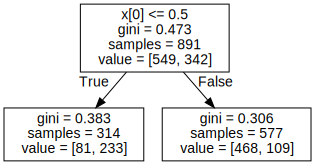

In [56]:
import graphviz
# sudo apt-get install graphviz
# Save tree as dot file
dot_data = tree.export_graphviz(tree_model, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 

The tree's graph show us that it consists of only one decision node that splits the data on the variable sex (the first variable, X[0]). All 314 females end up in one leaf node and all 577 males end up in a different leaf node.

Let's make predictions with this tree and view a table of the results:

In [57]:
# Get survival probability
preds = tree_model.predict_proba(X = pd.DataFrame(encoded_sex))

pd.crosstab(preds[:,0], titanic_train["Sex"])

Sex,female,male
row_0,,
0.257962,314,0
0.811092,0,577


The table shows that the decision tree managed to create the simple gender-based model where all females survive and all males perish.

Let's create a new decision tree that adds the passenger class variable and see how it changes the resulting predictions:

In [58]:
# Make data frame of predictors
predictors = pd.DataFrame([encoded_sex, titanic_train["Pclass"]]).T

# Train the model
tree_model.fit(X = predictors, 
               y = titanic_train["Survived"])

DecisionTreeClassifier()

Now let's look at the graph of the new decision tree model:

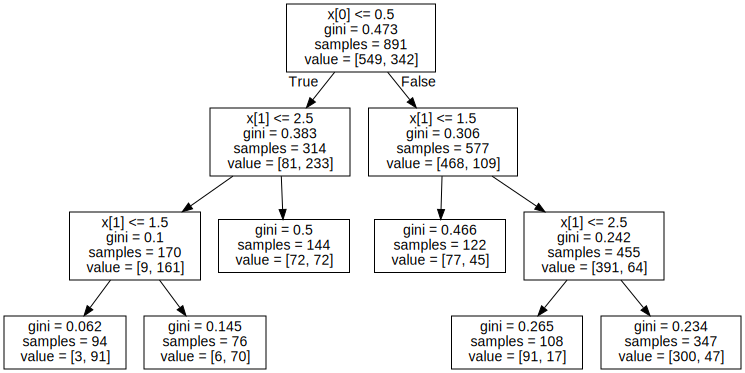

In [59]:
# Save tree as dot file
dot_data = tree.export_graphviz(tree_model, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 

Notice that by adding one more variable, the tree is considerably more complex. It now has 6 decision nodes, 6 leaf nodes and a maximum depth of 3.
Let's make predictions and view a table of the results:

In [60]:
# Get survival probability
preds = tree_model.predict_proba(X = predictors)

# Create a table of predictions by sex and class
pd.crosstab(preds[:,0], columns = [titanic_train["Pclass"], 
                                   titanic_train["Sex"]])

Pclass        1           2           3     
Sex      female male female male female male
row_0                                       
0.031915     94    0      0    0      0    0
0.078947      0    0     76    0      0    0
0.500000      0    0      0    0    144    0
0.631148      0  122      0    0      0    0
0.842593      0    0      0  108      0    0
0.864553      0    0      0    0      0  347

Notice that the more complex model still predicts a higher survival rate for women than men, but women in third class only have a 50% predicted death probability while women in first class are predicted to die less than 5% of the time.

The more variables you add to a decision tree, the more yes/no decisions it can make, resulting in a deeper, more complex tree. Adding too much complexity to a decision tree, however, makes it prone to overfitting the training data, which can lead to poor generalization to unseen data. Let's investigate by creating a larger tree with a few more variables:

In [61]:
predictors = pd.DataFrame([encoded_sex,
                           titanic_train["Pclass"],
                           titanic_train["Age"],
                           titanic_train["Fare"]]).T

# Initialize model with maximum tree depth set to 8
tree_model = tree.DecisionTreeClassifier(max_depth = 8)

tree_model.fit(X = predictors, 
               y = titanic_train["Survived"])

DecisionTreeClassifier(max_depth=8)

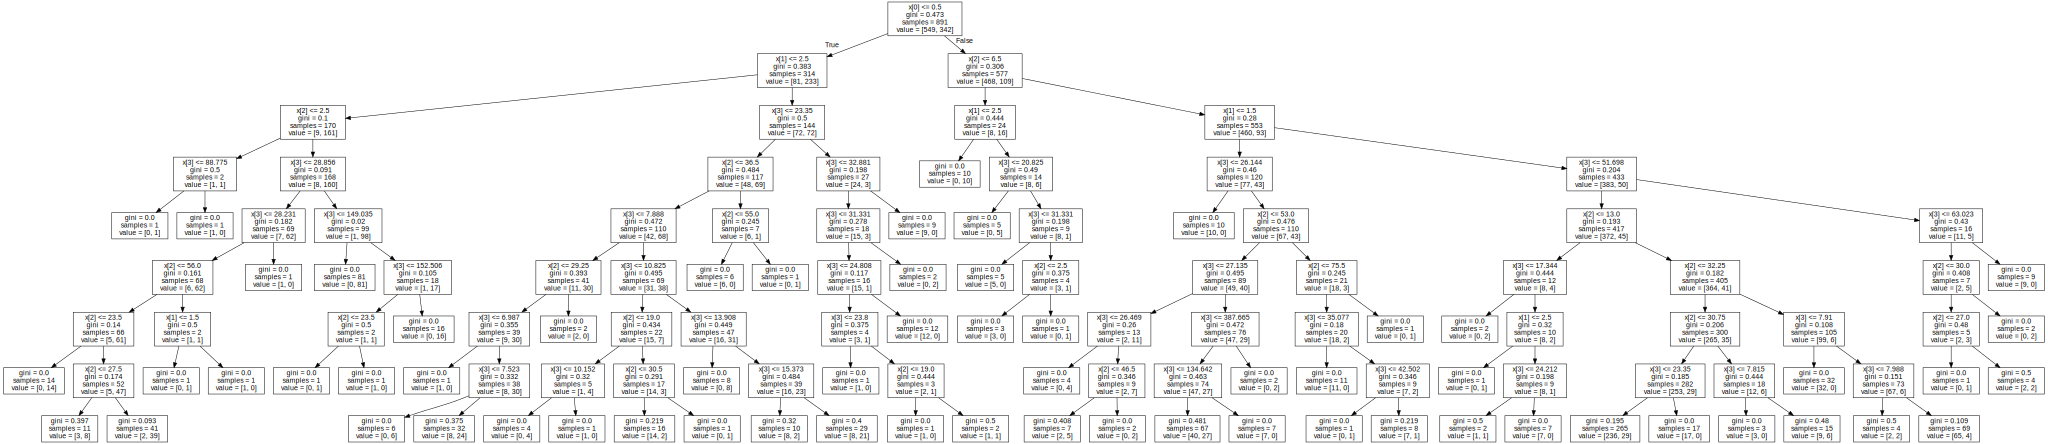

In [62]:
# Save tree as dot file
dot_data = tree.export_graphviz(tree_model, out_file=None) 
graph = graphviz.Source(dot_data)  
graph 

The image above illustrates how complex decision trees can become when you start adding more explanatory variables. You can control the complexity of the tree by altering some of the decision tree function's default parameters. For example, when we made the tree above, we set max_depth = 8, which limited the tree to a depth of 8 (if we hadn't done this the tree would have been much larger!).

For interest's sake, let's check the accuracy of this decision tree model on the training data:

In [63]:
tree_model.score(X = predictors, 
                 y = titanic_train["Survived"])

0.8877665544332211

The model is almost 89% accurate on the training data, but how does it do on unseen data? Let's load the test data, make some predictions submit them to Kaggle to find out:

In [64]:
# Read and prepare test data
titanic_test = pd.read_csv("test.csv")    # Read the data

# Impute median Age for NA Age values
new_age_var = np.where(titanic_test["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_test["Age"])      # Value if check is false

new_fare_var = np.where(titanic_test["Fare"].isnull(), # Logical check
                       50,                       # Value if check is true
                       titanic_test["Fare"])      # Value if check is false

titanic_test["Age"] = new_age_var 
titanic_test["Fare"] = new_fare_var

In [65]:
# Convert test variables to match model features
encoded_sex_test = label_encoder.fit_transform(titanic_test["Sex"])

test_features = pd.DataFrame([encoded_sex_test,
                              titanic_test["Pclass"],
                              titanic_test["Age"],
                              titanic_test["Fare"]]).T

In [66]:
# Make test set predictions
test_preds = tree_model.predict(X=test_features)

# Create a submission for Kaggle
submission = pd.DataFrame({"PassengerId":titanic_test["PassengerId"],
                           "Survived":test_preds})

# Save submission to CSV
submission.to_csv("tutorial_dectree_submission.csv", 
                  index=False)        # Do not save index values

Upon submission the model scores 0.78468 accuracy, which is slightly better than the simple gender-based model, but far worse than the accuracy the model achieved on the training data itself. This underscores the fact that predictive performance on the training data is a poor barometer of predictive performance on new data.

# Holdout Validation and Cross Validation

When creating a predictive model, we'd like to get an accurate sense of its ability to generalize to unseen data before actually going out and using it on unseen data. As we saw earlier, generating predictions on the training data itself to check the model's accuracy does not work very well: a complex model may fit the training data extremely closely but fail to generalize to new, unseen data. We can get a better sense of a model's expected performance on unseen data by setting a portion of our training data aside when creating a model, and then using that set aside data to evaluate the model's performance. This technique of setting aside some of the training data to assess a model's ability to generalize is known as validation.

Holdout validation and cross validation are two common methods for assessing a model before using it on test data. Holdout validation involves splitting the training data into two parts, a training set and a validation set, building a model with the training set and then assessing performance with the validation set. In theory, model performance on the hold-out validation set should roughly mirror the performance you'd expect to see on unseen test data. In practice, holdout validation is fast and it can work well, especially on large data sets, but it has some pitfalls.

Reserving a portion of the training data for a holdout set means you aren't using all the data at your disposal to build your model in the validation phase. This can lead to suboptimal performance, especially in situations where you don't have much data to work with. In addition, if you use the same holdout validation set to assess too many different models, you may end up finding a model that fits the validation set well due to chance that won't necessarily generalize well to unseen data. Despite these shortcomings, it is worth learning how to use a holdout validation set in Python.

You can create a holdout validation set using the train_test_split() in sklearn's cross_validation library:

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
v_train, v_test = train_test_split(titanic_train,     # Data set to split
                                   test_size = 0.25,  # Split ratio
                                   random_state=1,    # Set random seed
                                   stratify = titanic_train["Survived"]) #*

# Training set size for validation
print(v_train.shape)
# Test set size for validation
print(v_test.shape)

(668, 12)
(223, 12)


*Note: When performing classification, it is desirable for each class in the target variable to have roughly the same proportion across each split of the data. The stratify argument lets you specify a target variable to spread evenly across the train and test splits.*

The output above shows that we successfully created a new training set with roughly 75% of the original data and a validation test set with 25% of the data. We could proceed by building models with this new training set and making predictions on the validation set to assess the models.

Cross validation is a popular alternative to holdout validation that involves splitting the training data into two or more partitions and creating a model for each partition where the partition acts as the validation set and the remaining data acts as the training data. A common form of cross validation is "k-fold" cross validation, which randomly splits data into some number k (a user specified parameter) partitions and then creates k models, each tested against one of the partitions. Each of the k models are then combined into one aggregate final model.

The primary advantage of cross validation is it uses all the training data to build and assess the final model. The main drawback is that building and testing several models can be computationally expensive, so it tends to take much longer than holdout validation. You can create K cross validation splits of the data using the Kfold() function in sklearn's model_selection library:

In [69]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=12, shuffle=True)
kf.get_n_splits(titanic_train)

10

After creating a cross validation object, you can loop over each fold and train and evaluate a your model on each one:

In [70]:
fold_accuracy = []

titanic_train["Sex"] = encoded_sex

for train_fold, valid_fold in kf.split(titanic_train):
    train = titanic_train.loc[train_fold] # Extract train data with cv indices
    valid = titanic_train.loc[valid_fold] # Extract valid data with cv indices
    
    model = tree_model.fit(X = train[["Sex","Pclass","Age","Fare"]], 
                           y = train["Survived"])
    valid_acc = model.score(X = valid[["Sex","Pclass","Age","Fare"]], 
                            y = valid["Survived"])
    fold_accuracy.append(valid_acc)    

print("Accuracy per fold: ", fold_accuracy, "\n")
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

Accuracy per fold:  [0.8222222222222222, 0.7415730337078652, 0.8426966292134831, 0.7752808988764045, 0.8089887640449438, 0.9325842696629213, 0.8202247191011236, 0.8314606741573034, 0.8539325842696629, 0.8314606741573034] 

Average accuracy:  0.8260424469413234


Model accuracy can vary significantly from one fold to the next, especially with small data sets, but the average accuracy across the folds gives you an idea of how the model might perform on unseen data.

As with holdout validation, we'd like the target variable's classes to have roughly the same proportion across each fold when performing cross validation for a classification problem. To perform stratified cross validation, use the StratifiedKFold() function instead of KFold().

You use can score a model with stratified cross validation with a single function call with the cross_val_score() function:

In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
scores = cross_val_score(estimator= tree_model,     # Model to test
                X= titanic_train[["Sex","Pclass",   # Train Data
                                  "Age","Fare"]],  
                y = titanic_train["Survived"],      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print(scores)
print("Average accuracy: ", scores.mean())

Accuracy per fold: 
[0.73333333 0.82022472 0.75280899 0.85393258 0.87640449 0.78651685
 0.83146067 0.76404494 0.85393258 0.84269663]
Average accuracy:  0.8115355805243445


Notice that the average accuracy across each fold is higher than the non-stratified K-fold example. The cross_val_score function is useful for testing models and tuning model parameters (finding optimal values for arguments like maximum tree depth that affect model performance).

# Wrap Up

Decision trees are an easily interpretable yet surprisingly expressive form of predictive model. A decision tree of limited depth can provide a good starting point for classification tasks and model complexity is easy adjustable. For our final lesson, we'll learn about random forests, an extension of decision trees that preform very well on a wide range of classification tasks.

# Next Lesson: [Python for Data 30: Random Forests](https://www.kaggle.com/hamelg/python-for-data-30-random-forests)
[back to index](https://www.kaggle.com/hamelg/python-for-data-analysis-index)